### **Выполнил студент/староста гр. 6233-010402D Доружинский Дмитрий Владимирович**

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## **Предварительная подготовка dataset MNIST**

In [2]:
data_train = pd.read_csv('data/mnist_train.csv')
data_test = pd.read_csv('data/mnist_test.csv')

print(f'Dataset MNIST - объёмная база данных образцов рукопасного написания цифр.\nРазмерность train: {data_train.shape}, test: {data_test.shape}')

Dataset MNIST - объёмная база данных образцов рукопасного написания цифр.
Размерность train: (60000, 785), test: (10000, 785)


In [3]:
# Уменьшение размерности в условиях ограниченых ресурсов
data_train = data_train[:1000]
data_test = data_test[:100]

print(f'Новая размерность: train: {data_train.shape}, test: {data_test.shape}')

Новая размерность: train: (1000, 785), test: (100, 785)


In [4]:
# Вывод первых 10 значений тренировочной выборки
data_train[0:10]

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


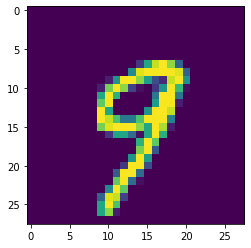

In [5]:
# Визуализация одного из значений
img = np.reshape(list(data_train.iloc[57][1:785]), (28, 28))
plt.imshow(img)

In [6]:
# Подготовка значений признаков
data_train_not_label = data_train[:]
data_test_not_label = data_test[:]

del data_train_not_label['label']
del data_test_not_label['label']

X_train = data_train_not_label
X_test = data_test_not_label

# Нормировка данных
X_train /= 255
X_test /= 255

# Преобразование в numpy массив
X_train = data_train_not_label.to_numpy()
X_test = data_test_not_label.to_numpy()
print(f'Размерность признаков, train: {X_train.shape}, test: {X_test.shape}.')

Размерность признаков, train: (1000, 784), test: (100, 784).


In [7]:
# Подготовка меток классов при помощи OneHot алгоритма для кодировки
from sklearn.preprocessing import OneHotEncoder

encoding = OneHotEncoder(sparse_output=False, handle_unknown='error')
labels = pd.concat([data_train[['label']], data_test[['label']]])
encoding.fit(labels)

y_train = pd.DataFrame(encoding.transform(data_train[['label']]))
y_test = pd.DataFrame(encoding.fit_transform(data_test[['label']]))

# Преобразование в numpy массив
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
print(f'Размерность меток классов, train:  {y_train.shape}, test: {y_test.shape}.\n\n {y_train[0:6]}')

Размерность меток классов, train:  (1000, 10), test: (100, 10).

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

In [9]:
# Функция активакии Relu
def relu(x):
    return (x > 0) * x

# Производная функции активации
def relu_two_deriv(x):
    return x>0

# Модель предсказания трехслойной системы
def model_prediction(input, weights_0_1, weights_1_2):
    layer_0 = input
    layer_1 = relu(np.dot(layer_0,weights_0_1))
    layer_2 = np.dot(layer_1,weights_1_2)
    return layer_2

## **Стохастический градиентный спуск**

In [10]:
# Гиперпараметры сети
np.random.seed(1)
learning_rate = 0.005
hidden_size = 100
input_size = 784
num_labels = 10

# Веса между входным и скрытым слоями
weights_input_hidden = (2*np.random.random((input_size,hidden_size)) - 1) / np.sqrt(input_size)
# Веса между скрытым и выходным слоями
weights_hidden_output = (2*np.random.random((hidden_size, num_labels)) - 1) / np.sqrt(hidden_size)

# Массивы для записи
array_iteration = []
array_error = []
array_accuracy = []
text_file = open("train.txt", "w+")
for iteration in range(10):
    error = 0
    for i in range(len(X_train)):
     # Прямой проход
        input_layer = X_train[i:i+1]
        hidden_layer = relu(np.dot(input_layer,weights_input_hidden))
        output_layer = np.dot(hidden_layer,weights_hidden_output)

        error = error + np.sum((output_layer - y_train[i:i+1]) ** 2)

        # Обратный проход
        diff_between_output_hidden = 2*(output_layer - y_train[i:i+1])
        weight_hidden_output_corrections = hidden_layer.T.dot(diff_between_output_hidden) # Величина коррекции для весов между layer_1 и layer_2

        diff_between_input_hidden = diff_between_output_hidden.dot(weights_hidden_output.T)*relu_two_deriv(hidden_layer)
        weight_input_hidden_corrections = input_layer.T.dot(diff_between_input_hidden)

        weights_hidden_output = weights_hidden_output - learning_rate * weight_hidden_output_corrections
        weights_input_hidden = weights_input_hidden - learning_rate * weight_input_hidden_corrections

    if(iteration % 2 == 0):
        print(f'Iteration = {iteration}\nError: {error}')
        array_iteration.append(iteration)
        array_error.append(error)
        goal_idx = np.argmax(y_train[:100], axis=1)
        y_prediction = model_prediction(X_train[:100], weights_input_hidden, weights_hidden_output)
        pred_idx = np.argmax(y_prediction, axis=1)
        accuracy = accuracy_score(goal_idx ,pred_idx)
        array_accuracy.append(accuracy)
        print(f'Accuracy: {accuracy}\n')
       
        text_file.write(str(' |Iteration '))
        text_file.write(str(iteration))
        
        text_file.write(str(' |Erorr '))
        text_file.write(str(error))
        
        text_file.write(str(' | accuracy '))
        text_file.write(str(accuracy))
        text_file.write(str('\n'))
        

text_file.close()

Iteration = 0
Error: 534.0169256110769
Accuracy: 0.84

Iteration = 2
Error: 247.19582428935448
Accuracy: 0.93

Iteration = 4
Error: 169.70247808369385
Accuracy: 0.97

Iteration = 6
Error: 130.05865411330993
Accuracy: 0.97

Iteration = 8
Error: 104.84209913724405
Accuracy: 0.97



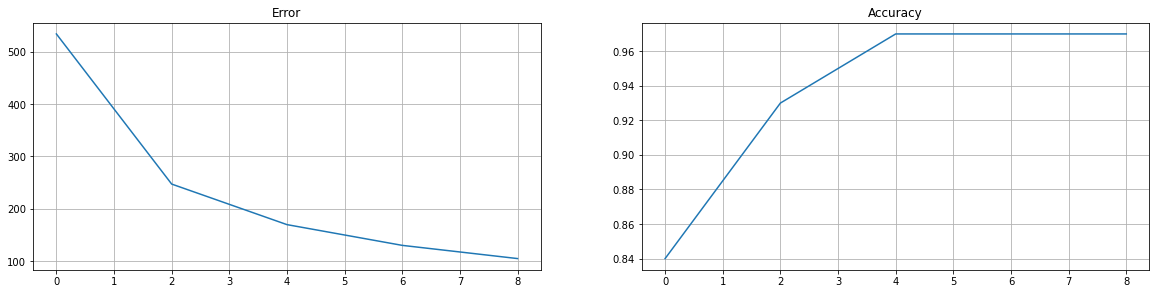

In [11]:
# Построение графиков Error и Accuracy
graph = plt.figure(figsize=(20, 10), constrained_layout=False)

error_range = np.linspace(0.18, 0)

subgraph_1 = graph.add_subplot(221)
subgraph_1.plot(array_iteration, array_error)
subgraph_1.set_title('Error')
plt.grid()

subgraph_2 = graph.add_subplot(222)
subgraph_2.plot(array_iteration, array_accuracy)
subgraph_2.set_title('Accuracy')
plt.grid()